# Report on EEG Attention Dataset Analysis

## Introduction

This report presents the analysis of an EEG dataset focused on attention levels. The analysis includes data preprocessing, training multiple machine learning models, and evaluating their performance. We will visualize various aspects of the data and the performance of the models.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv(r"C:\Users\91981\Desktop\Project_EEG\EEg\eeg_attention_reduced_correlation_dataset.csv")

# Drop 'Timestamp' and 'Subject ID' columns
df.drop(['Timestamp', 'Subject ID'], axis=1, inplace=True)

## 1. Distribution of 'Attention Level'

This plot shows the count of different categories in the 'Attention Level' column.


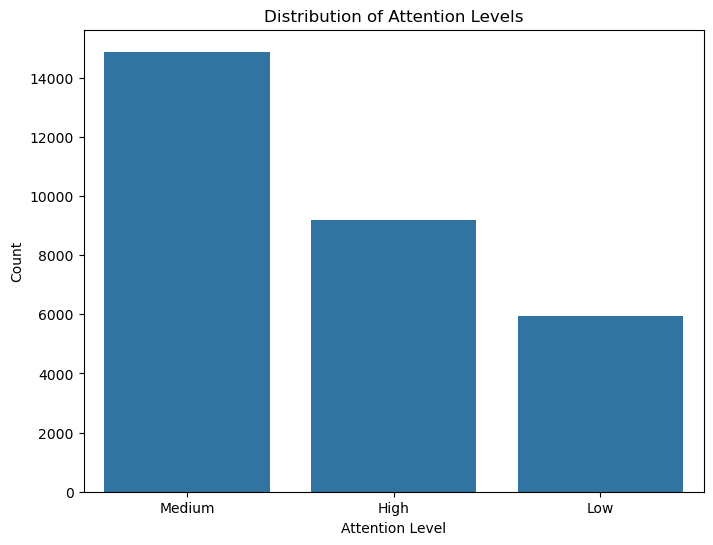

In [37]:
# Exploratory Data Analysis (EDA)
# 1. Distribution of 'Attention Level'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Attention Level')
plt.title('Distribution of Attention Levels')
plt.xlabel('Attention Level')
plt.ylabel('Count')
plt.show()

## Encoding Categorical Columns and 'Attention Level'

The categorical columns are one-hot encoded, and the 'Attention Level' column is label encoded to convert it into numerical format for further analysis.


In [38]:
# Encode categorical columns and 'Attention Level'
categorical_columns = ['Signal Quality', 'Task Difficulty', 'Mental Fatigue']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
label_encoder = LabelEncoder()
df['Attention Level'] = label_encoder.fit_transform(df['Attention Level'])

## 2. Correlation Heatmap

This heatmap shows the correlations between different features in the dataset, helping to identify the strength and direction of linear relationships between variables.


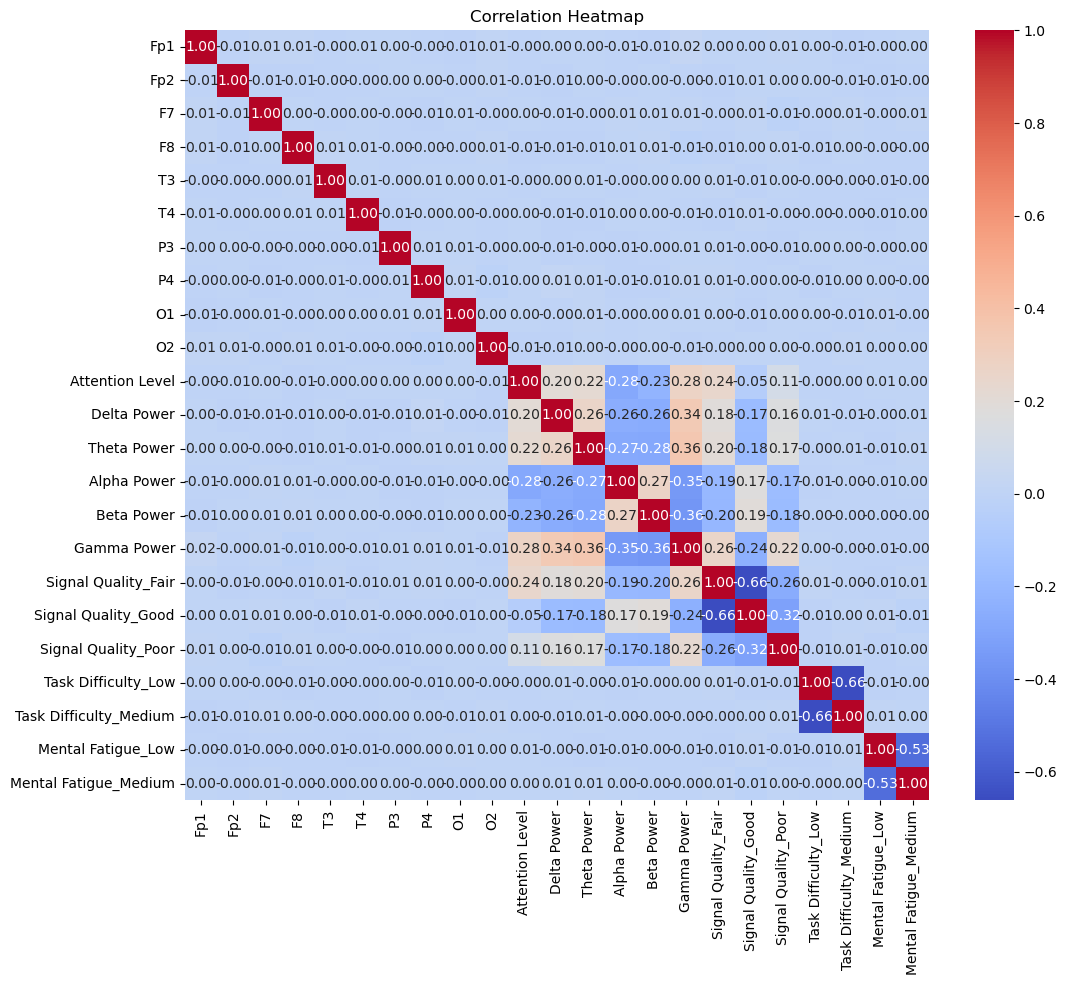

In [39]:

# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Separating Features and Target Variable, Normalizing, and Splitting Data

The feature set is separated from the target variable ('Attention Level'), then normalized using MinMaxScaler. The dataset is split into training and testing sets with a 70-30 ratio to prepare for model training and evaluation.


In [54]:
# Separate features and target variable
X = df.drop('Attention Level', axis=1)
y = df['Attention Level']

# Normalize the feature set
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## 4. Feature Importance from RandomForestClassifier

This section uses a RandomForestClassifier to determine the importance of each feature in predicting 'Attention Level'. The features are ranked based on their contribution to the model, and the importance is visualized using a bar plot.


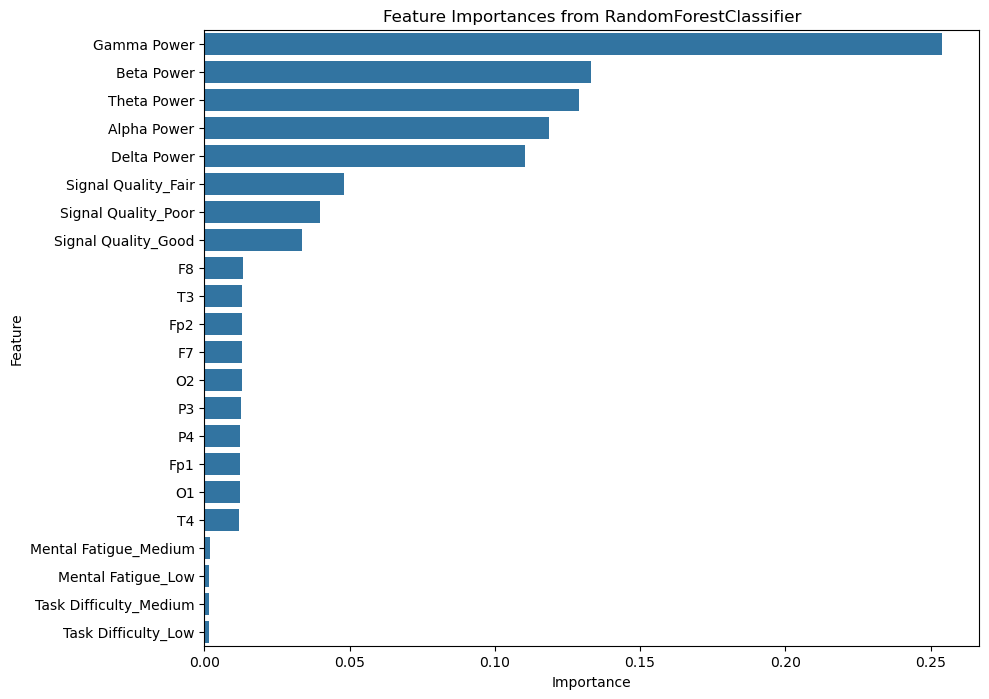

In [42]:
# 4. Feature Importance from RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=42)
rf_classifier.fit(X_train, y_train)
feature_importances = rf_classifier.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from RandomForestClassifier')
plt.show()


In [43]:
# Train and evaluate RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

print("RandomForestClassifier Results:")
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


RandomForestClassifier Results:
[[2539    0  208]
 [   0 1552  214]
 [ 360   33 4094]]
Accuracy: 0.9094444444444445


## Training and Evaluating RandomForestClassifier

A RandomForestClassifier is trained on the training data and then evaluated on the test data. The performance is measured using a confusion matrix and accuracy score to assess how well the model predicts 'Attention Level'.


In [44]:

# Train and evaluate XGBoostClassifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

print("XGBoostClassifier Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoostClassifier Results:
Confusion Matrix:
 [[2489    0  258]
 [   0 1567  199]
 [ 307   39 4141]]
Accuracy: 0.9107777777777778


## Training and Evaluating SVM

An SVM with a linear kernel is trained on the training data and evaluated on the test data. The performance is assessed using a confusion matrix and accuracy score to evaluate the model's effectiveness in predicting 'Attention Level'.


In [45]:

# Train and evaluate SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

print("SVM Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Results:
Confusion Matrix:
 [[2209    0  538]
 [   0 1455  311]
 [ 367  194 3926]]
Accuracy: 0.8433333333333334


## ANN using Keras

An Artificial Neural Network (ANN) is built with Keras, consisting of three hidden layers with ReLU activation and an output layer with softmax for multi-class classification. The model is trained with early stopping to prevent overfitting, monitoring validation loss and restoring the best weights.



In [50]:

# ANN using Keras
def build_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 classes for Attention Level

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train ANN with Early Stopping
ann_model = build_ann_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,mode='min')

history = ann_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test),validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\91981\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6801 - loss: 0.6573 - val_accuracy: 0.8171 - val_loss: 0.4173
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8338 - loss: 0.3871 - val_accuracy: 0.8327 - val_loss: 0.3760
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8473 - loss: 0.3533 - val_accuracy: 0.8394 - val_loss: 0.3659
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8492 - loss: 0.3527 - val_accuracy: 0.8391 - val_loss: 0.3648
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8451 - loss: 0.3561 - val_accuracy: 0.8356 - val_loss: 0.3693
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8446 - loss: 0.3555 - val_accuracy: 0.8414 - val_loss: 0.3619
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8544 - loss: 0.3418 - val_accuracy: 0.8351 - val_loss: 0.3708
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8481 - loss: 0.3449 - val_accuracy: 0.8390

## Plot Training & Validation Loss Values

This plot shows the loss curves for both training and validation data over epochs. It helps visualize how well the model is learning and whether it is overfitting or underfitting.


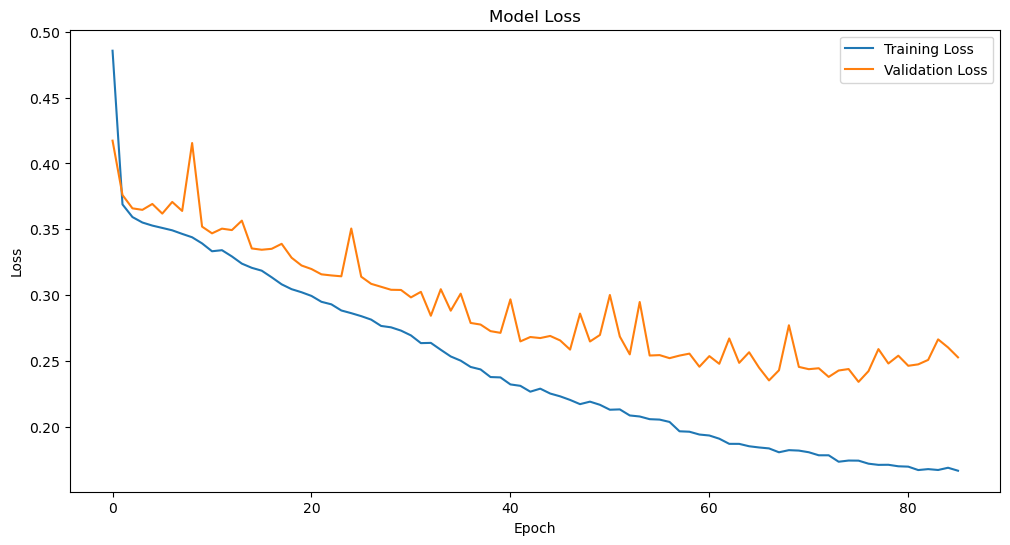

In [51]:

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

## Plot Training & Validation Accuracy Values

This plot illustrates the accuracy of the model on both training and validation datasets over epochs. It helps to assess how well the model is performing and whether the training process is leading to improved accuracy.


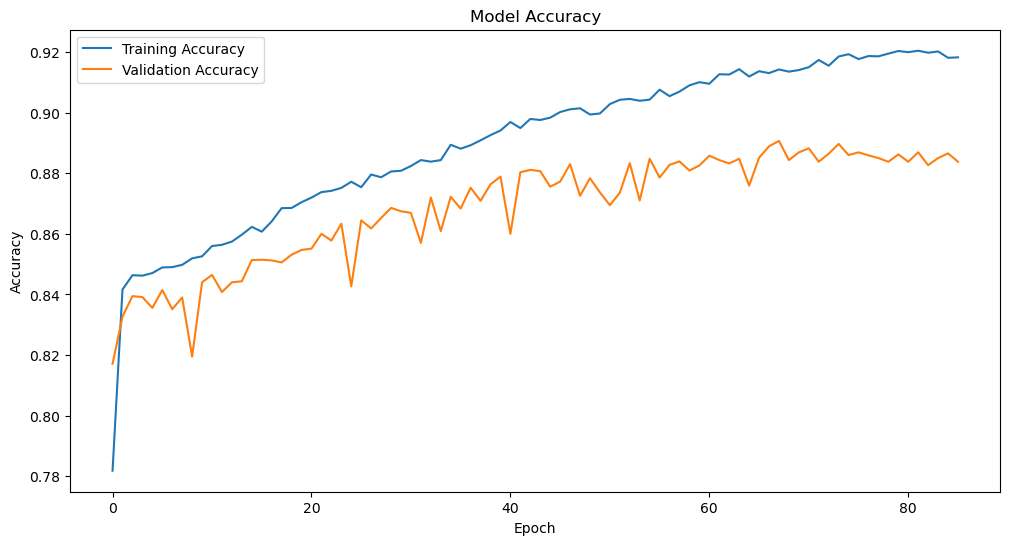

In [52]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Evaluate ANN Model and Cross-Validation

The ANN model's performance is evaluated on the test set with a confusion matrix and accuracy score. Additionally, K-Fold Cross-Validation is performed to assess the stability and performance of RandomForestClassifier, XGBoostClassifier, and SVM across different subsets of the data.



In [53]:

# Evaluate ANN model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)

print("ANN Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Accuracy:", accuracy_score(y_test, y_pred_ann))

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Collect cross-validation results
cv_results_rf = cross_val_score(rf_classifier, X_scaled, y, cv=kf, scoring='accuracy')
cv_results_xgb = cross_val_score(xgb_classifier, X_scaled, y, cv=kf, scoring='accuracy')
cv_results_svm = cross_val_score(svm_classifier, X_scaled, y, cv=kf, scoring='accuracy')

print("RandomForestClassifier Cross-Validation Accuracy:", np.mean(cv_results_rf))
print("XGBoostClassifier Cross-Validation Accuracy:", np.mean(cv_results_xgb))
print("SVM Cross-Validation Accuracy:", np.mean(cv_results_svm))

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
ANN Results:
Confusion Matrix:
 [[2434    0  313]
 [   0 1579  187]
 [ 370  148 3969]]
Accuracy: 0.8868888888888888
RandomForestClassifier Cross-Validation Accuracy: 0.9133333333333334
XGBoostClassifier Cross-Validation Accuracy: 0.9100333333333334
SVM Cross-Validation Accuracy: 0.8508333333333333


## Conclusion

In this analysis, various models were applied to predict 'Attention Level':

- **RandomForestClassifier**: Provided feature importances and demonstrated its performance through accuracy and confusion matrix.
- **Support Vector Machine (SVM)**: Evaluated with linear kernel, and its accuracy was measured to understand its effectiveness.
- **Artificial Neural Network (ANN)**: Built and trained with Keras, showing training and validation loss and accuracy over epochs. The model's performance was assessed using a confusion matrix and accuracy score.
- **Cross-Validation**: Used to gauge the robustness of RandomForestClassifier, XGBoostClassifier, and SVM across different data splits, providing insights into model stability.

The results from these models provide a comprehensive view of their performance and help in selecting the most suitable model for predicting 'Attention Level'.
